In [443]:
import numpy as np
import matplotlib.pyplot as plt
import random

First we define the possible inputs for the logical operators in an array x and create arrays for 5 logical operators specifying which elements of x as inputs evaluate as True and which of them evaluate as False.

In [444]:
x = np.array([[0,0],[0,1],[1,0],[1,1]])

target_and = np.array([0,0,0,1])
target_or = np.array([0,1,1,1])
target_nand = np.array([1,1,1,0])
target_xor = np.array([0,1,1,0])
target_nor = np.array([1,0,0,0])

Now we define some functions that we will use. We define the sigmoid and it's derivative where we define the derivative without referring to the sigmoid function to make use of previously computed activation values in the backpropagation scheme. 

We also define a function to evaluate the accuracy of our logical-gate model later on.

In [445]:
def sigmoid(x):
    return 1 / (1 + np.exp(-1*x))

def sigmoid_prime(sigm):
    """
    If sigm is the result of sigmoid(x), this computes the derivative of sigmoid(x)
    """
    return sigm*(1-sigm)

def accuracy_func(t, y_hat):
    if ((t==1) and (y_hat>=0.5)) or ((t==0) and (y_hat<0.5)):
        return True
    else:
        return False

We define a class for individual Perceptrons. These will be the basis for our MLP. Each Perceptron can be thought of as a unit with inputs that are taken into a weighted sum by the weights that are are stored in a variable of the Perceptron. These weights are a 1D array (or a vector) and they contain at index 0 the Perceptron's bias. So we incorporated the bias into the weights, which means we also have to add an additional value of 1 at index 0 to the Perceptron's inputs.

The result is called the Perceptron's drive on which an activation function (here by default set to be the sigmoid function) is applied, the result of which is called the Perceptron's activation.

The idea of storing the activation and drive inside the neuron is so we can reuse these values, saving computational cost of computing them again. 

Finally we also define an update method for the Perceptron's weights (including the bias). This update method needs the error signal (delta) of the Perceptron. It can be understood as the contribution to the network error of this unit. 

In [446]:
class Perceptron:
    
    def __init__(self, input_units, lr, act_func= sigmoid):
        # set number of inputs
        self.input_units = input_units
        
        # initialize weighted connections from inputs to the Perceptron
        self.weights = np.random.randn(input_units +1) # +1 for bias weights
        
        # set learning rate
        self.lr = lr
        
        # initialize activation function variable
        self.act_func = act_func
        
        # to keep track of this Perceptron's drive and activation, initialize variables for drive
        # and the inputs it receives.
        self.drive = 0
        self.inputs = 0
        self.activation = 0
        
        # initialize the error signal for the perceptron
        self.delta = None
        
    def forward_step(self, inputs):
        """
        Performs a forward step for the perceptron.
        """
        
        # insert a value of 1 as the first entry in the perceptrons inputs 
        #(activations from previous layer or the MLPs input) for the bias 
        self.inputs = np.insert(inputs,0,1)
        
        # calculate the weighted sum of inputs weighted by their weights
        self.drive =  self.weights @ self.inputs
        
        # return the activation for the Perceptron given the inputs and weights(including bias)
        self.activation = self.act_func(self.drive)
        return self.activation
    
    def update(self, delta):
        """
        This will allow to update weights associated with this perceptron given that we have it's delta.
        """
        
        # compute gradients of the weights to this perceptron (including bias) by multiplying it's error signal with
        # the it's unweighted inputs (including a 1 at index 0 for the bias weights)
        gradient_weights = delta * self.inputs
        
        # update the weights (including bias) by subtracting learning rate * gradients 
        self.weights -= self.lr * gradient_weights

The idea now is to rely on this class of individual Perceptrons with their own weights (connections to the Perceptron's input) for building a neural network, a multi-layer-perceptron, MLP.

We define this class such that it is possible to specify the input dimensions, the number of hidden layers and the output dimensions (though with the current activation functions applied to output units, it is intended to use only one output). 

An MLP consists of hidden layers, where the first layer is connected to the input, and the output units. For each hidden layer we instantiate the number of Perceptrons given by the argument total_dim. We make sure that the number of weights of these Perceptrons matches the number of Perceptrons or input units in the previous layer. 

Since each Perceptron can compute it's drive and activation given that we already know the previous activations/inputs, in the MLP-forward-step, we just go through the hidden units layer by layer and in each layer unit by unit and calculate their outputs (these are then stored in the Perceptron objects activation variable). Finally we obtain the outputs of the output neurons. 

The weights were initialized randomly in the Perceptron class, the outputs will probably not match the true target value (e.g.for the logical operator "a and b" a=1,b=1 should evaluate to True). This is why we use the backpropagation method to calculate the error signals for all hidden and output units. To propagate the error signal from the output units back to the  hidden units in the first hidden layer, we use these two formulas:

For the output units, this is a rather simple.
$\delta_i^{(l)}$ = $-(t_i - y_i)$ $\sigma^{'}(d_i^{(N)})$

For the Perceptron units in the layers before the output all the way until the input layer we use this formula to compute the error signals:

$\delta_i^{(l)} = (\sum_{k = 1}^{m} \delta_k^{(l+1)} w_{ki}^{(l+1)}) \sigma^{'}(d_i^{(l)})$




Having obtained the error signals, we can finally update the weights.

In [447]:
class MLP:
    """
    input dimensions, hidden dimensions and output dimensions given as lists in distinct arguments
    """
    def __init__(self, total_dim, alpha = 0.01):
        
        input_dim = total_dim[0]
        hidden_dim = total_dim[1:-1]
        output_dim = total_dim[-1]
        
        # create a nested list of Perceptrons where each perceptron has the input_units set to 
        # the previous layer's number of units (including input units at n=0)
        self.hidden_layers = [
                [Perceptron(input_units = total_dim[n],lr = alpha) for _ in range(layer_units)] 
                 for n, layer_units in enumerate(hidden_dim)
        ]
        
        # initialize perceptrons for the output units (in case we have multiple outputs)
        self.output_units = [Perceptron(input_units = hidden_dim[-1], lr = alpha) for _ in range(output_dim)]
        
        # initialize MLP output to 0 and initialize an empty list for individual layer's perceptron's activations
        self.output = [0 for _ in range(output_dim)]
        self.layer_activations = []
        
    
    def forward_step(self, inputs):
        """
        Perform a forward step given inputs
        """
        # make sure inputs match the input_units for the first hidden layer perceptrons.
        assert len(inputs) == len(self.hidden_layers[0][0].weights) - 1,'input dimension should match the initalisation'
        
        self.layer_activations = [inputs]
        
        # for each layer calculate the activation for all it's perceptrons. 
        # Then store these activations in a list and store this list in a list for all layer's activations.
        for layer in self.hidden_layers:
            activations = []
            for unit in layer:
                unit_activation = unit.forward_step(self.layer_activations[-1])
                activations.append(unit_activation)
            self.layer_activations.append(activations)
        
        # calculate output
        self.output = [out_unit.forward_step(self.layer_activations[-1]) for out_unit in self.output_units]
        
    def backprop_step(self, targets):
        
        error_signals = []
        # Start by calculating error signals for the output units.
        
        # For this we use the formula delta_i = -(target_i - output_i) * sigmoid_prime(drive of output unit_i)
        # create a nested list for the deltas in each layer
        error_signals = []
        output_deltas = []
        for i, (target, output) in enumerate(zip(targets,self.output)):
            
            # we want to reuse the activation values and not recompute the sigmoid
            delta_i = -(target - output) * (sigmoid_prime(self.output_units[i].activation))
            
            #store delta in a variable of the perceptron unit
            self.output_units[i].delta = delta_i
            
            # append error signal to output error signals list
            output_deltas.append(delta_i)
            
            # perform weight update for output unit i using the error signal associated with this unit
            self.output_units[i].update(delta_i)
            
        error_signals.append(output_deltas)
        
        # now compute the error signals for the hidden layers, 
        # to do this, we compute the sums for all units in a layer simultaneously and then multiply
        # the corresponding sum_i for unit_i in layer l with the sigmoid derivative of unit_i's drive.
        
        for n, layer in enumerate(reversed(self.hidden_layers)):
            # initialize a list of error signals for this layer
            layer_deltas = []
            sums_for_layer = np.zeros(len(layer))
            
            # since output units and hidden units are stored in independent variables, we have a
            # slightly different procedure for n == 0.
            
            if n == 0:
                for o_unit_k in self.output_units:
                    sums_for_layer += o_unit_k.delta * np.array(o_unit_k.weights[1:])
                
                for i, sum_i in enumerate(sums_for_layer):
                    # multiply the sum for unit i by the sigmoid derivative of it's drive to obtain it's delta
                    delta = sum_i * sigmoid_prime(layer[i].activation)
                    layer_deltas.append(delta)
                    layer[i].delta = delta
                error_signals.append(layer_deltas)
                    
            else:
                # for hidden layer n that aren't connected to the output layer
                for hidden_unit_k in self.hidden_layers[::-1][n-1]: # [::-1] for reversal of list, n-1 to 
                    sums_for_layer += hidden_unit_k.delta * np.array(hidden_unit_k.weights[1:])
                    
                for i, sum_i in enumerate(sums_for_layer):
                    delta = sum_i * sigmoid_prime(layer[i].activation)
                    layer_deltas.append(delta)
                    layer[i].delta = delta
                
                error_signals.append(layer_deltas)
        
        # once we have all the deltas computed without having updated weights in between 
        #(this would distort the process), we update the weights.
        
        # update unit using the delta we assigned to it
        for unit in self.output_units:
            unit.update(unit.delta)
            
        for layer in self.hidden_layers:
            for unit in layer:
                unit.update(unit.delta) 
        

                    

The following is a test for accuracy of this architecture/implementation trained on the 5 different logical connectors. We show that the network is able to learn all of the logical operators with 100% (4/4 correct) accuracy.

We train using stochastic gradient descent (batch size = 1) with 1000 epochs over 4 training examples for each operator.

The MLP has 2 input units, 4 hidden units in one layer and 1 output unit.

In [448]:
logs = {} # create dictionary to store results in

# for each logical operator, compute for each epoch the avg losses and accuracies

for name, logical_operator in [("and", target_and), ("or", target_or), ("nand",target_nand), ("xor",target_xor), 
                               ("nor",target_nor)]:
    
    
    accuracies = []
    losses = []
    avg_loss = np.array([])
    avg_accuracies= np.array([])
    
    # instantiate a MLP with 2 inputs, 1 hidden layer with 4 units and 1 output unit
    
    # set learning rate to 0.2 instead of 0.01 to achieve better results in 1000 epochs
    learning_rate = 0.2
    mlp = MLP([2,4,1], alpha= learning_rate)
    
    # train for 1000 epochs
    epochs = 1000
    
    a = np.arange(len(x)) # define possible indices for shuffling
    
    for epoch in range(epochs):
        # shuffling x and targets in each epoch
        random.shuffle(a)
        x_shuffled = x[a]
        y_shuffled= logical_operator[a]

        #training on each observation(x and y pair)
        for x_i,t_i in zip(x_shuffled,y_shuffled):
            mlp.forward_step(x_i)
            mlp.backprop_step([t_i])

        # compute accuracy for the current epoch and append to accuracies list.
        # also compute the total squared error for an epoch
        accuracy = 0
        loss = 0
        for x_i,y_i in zip(x,logical_operator):
            mlp.forward_step(x_i)
            accuracy += accuracy_func(y_i, mlp.output[0])
            
            loss += (y_i - mlp.output[0])**2
            
        accuracy= accuracy/len(x)
        accuracies.append(accuracy)
        losses.append(loss)
        # compute the average accuracy and loss for current epoch.
        avg_accuracies = np.append(avg_accuracies, np.mean(accuracies))
        avg_loss = np.append(avg_loss, np.mean(losses))
        
    logs[name] = {"losses": losses, "accuracies": accuracies, "avg_loss":avg_loss,
                  "avg_accuracies": avg_accuracies}
    
    print("final accuracy for", name, "is:",accuracies[-1])
    

final accuracy for and is: 1.0
final accuracy for or is: 1.0
final accuracy for nand is: 1.0
final accuracy for xor is: 1.0
final accuracy for nor is: 1.0


**Plot the results**

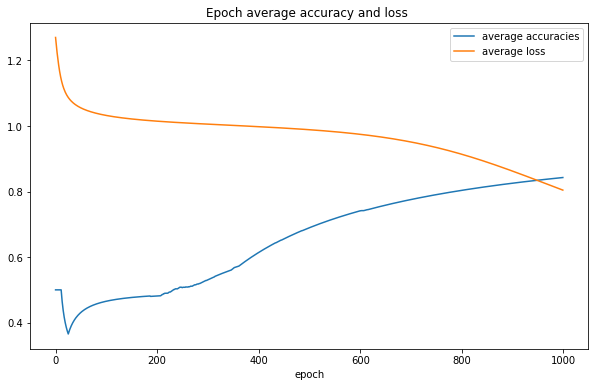

In [449]:
what_to_plot = "xor" # change this to view results for other logical operators

fig, ax = plt.subplots(ncols=1, figsize=(10,6))

ax.plot(logs[what_to_plot]["avg_accuracies"])
ax.set(title='Epoch average accuracy and loss ', xlabel = 'epoch')
ax.plot(logs[what_to_plot]["avg_loss"])
ax.legend(["average accuracies","average loss"])